# PA005 - High Value Customer Identification (Insiders)

# Planejanamento da solução (IoT)

## Input - Entrada
    

1. Problema do negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce online durante o período de um ano

## Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
                10323  | yes/1
                32413  | no/1
                
                
2. Relatório
    1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    2. Quantos clientes farão parte do grupo?
    3. Quais as principais características desses clientes ?
    4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    7. Quais as condições para uma pessoa ser removida do Insiders ?
    8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento: 
        - Alto ticket médio.
        - Alto LTV (life time value).
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixo taxa de devolução
        
    - Experiência 
        - Média alta de avaliação
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de cliente
    - % do grupo de Insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente:
        Idade
        Localização
    - Escrever características do consumo:
        Atributos da clusterização
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort 
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo
    
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser dessimilar ou parecido com uma pessoa do grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frente
    - Visita a empresa

# Imports

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

In [18]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# Load dataset

In [19]:
df_raw = pd.read_csv('datasets/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1 )

In [20]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
150218,549368,22383,LUNCH BAG SUKI DESIGN,2,6-Apr-17,1.65,18036.0,United Kingdom
246730,558714,51014C,"FEATHER PEN,COAL BLACK",12,29-Jun-17,0.39,17888.0,United Kingdom
103423,545063,22134,MINI LADLE LOVE HEART RED,1,25-Feb-17,0.42,14606.0,United Kingdom
88058,C543755,22311,OFFICE MUG WARMER BLACK+SILVER,-6,9-Feb-17,2.95,14304.0,United Kingdom
23192,538184,20979,36 PENCILS TUBE RED RETROSPOT,16,8-Dec-16,1.25,17880.0,United Kingdom
90288,543995,22726,ALARM CLOCK BAKELIKE GREEN,12,13-Feb-17,3.75,13408.0,United Kingdom
370,536401,20726,LUNCH BAG WOODLAND,1,29-Nov-16,1.65,15862.0,United Kingdom
371842,569228,22318,FIVE HEART HANGING DECORATION,2,30-Sep-17,2.95,15547.0,United Kingdom
291499,562456,84879,ASSORTED COLOUR BIRD ORNAMENT,24,3-Aug-17,1.69,15194.0,United Kingdom
143019,548663,22352,LUNCH BOX WITH CUTLERY RETROSPOT,2,30-Mar-17,4.96,NaN,United Kingdom


# Descrição dos dados

In [21]:
df1 = df_raw.copy()

## Rename Columns

In [22]:
cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_news

## Data dimensions

In [23]:
df1.shape

(541909, 8)

## Data types

In [24]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Data Check NA

In [25]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [26]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format( 1 - (df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25%


## Change dtypes

In [27]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [28]:
#invoice_date
df1['invoice_date'] =pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

In [29]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Descriptive Statistics

# Feature Engineering

In [30]:
df2 = df1.copy()

## Feature Creation

In [31]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [32]:
 # data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description',
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [33]:
# Gross Revenue ( Faturamento = quantity * price)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

#monetary (quanto essa pessoa gastou até o momento)
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')





In [34]:
#avg ticket (ticket médio)
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

In [35]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# Filtragem de variáveis

In [36]:
df3 = df_ref.copy()

# EDA (Explory Data Analysis)

In [37]:
df4 = df3.copy()

# Data Preparation

In [38]:
df5 = df4.copy()

# Feature Selection

In [39]:
df6 = df5.copy()

# Hyperparameter Fine-Tunning

In [40]:
X = df6.drop(columns=['customer_id'])

In [41]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


##  Within-Cluster Sum of Square (Wss)

In [42]:
clusters = [2, 3, 4, 5, 6, 7]

Text(0.5, 1.0, 'WSS vs K')

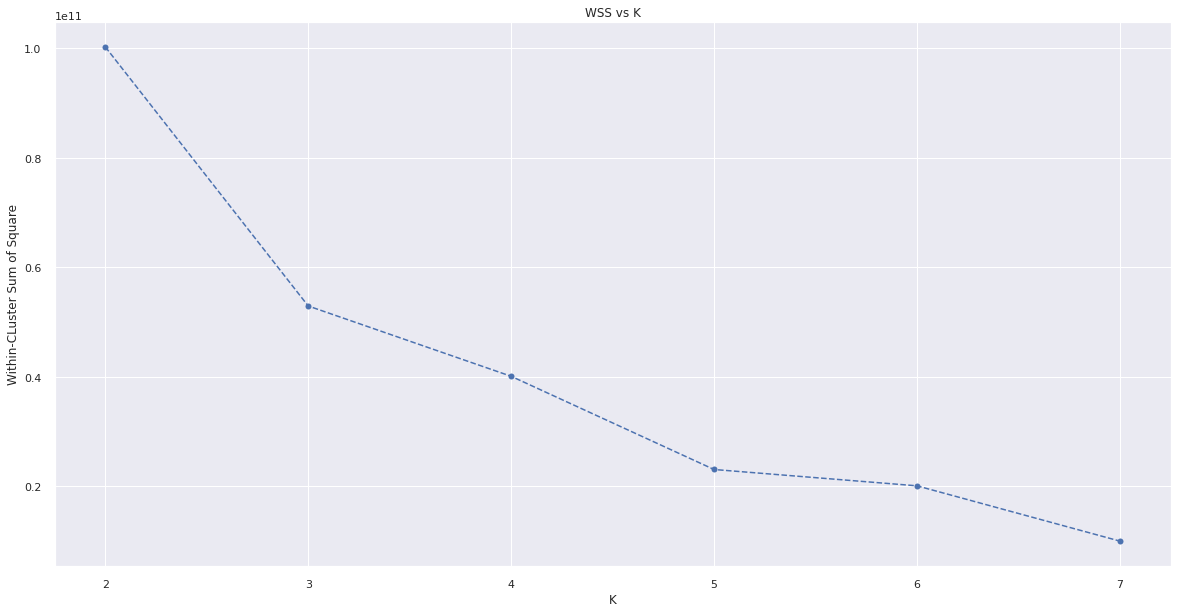

In [43]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans( init='random', n_clusters = k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit( X )
    
    #validation
    wss.append(kmeans.inertia_)
    
#plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-CLuster Sum of Square')
plt.title('WSS vs K')

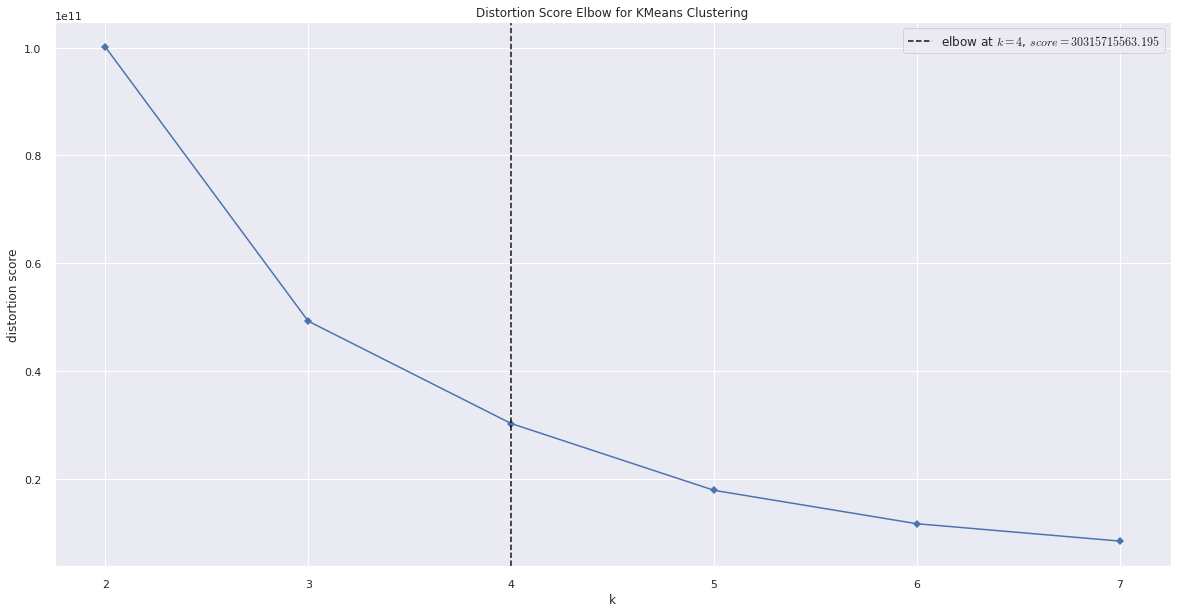

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show()

## Silhouette Score

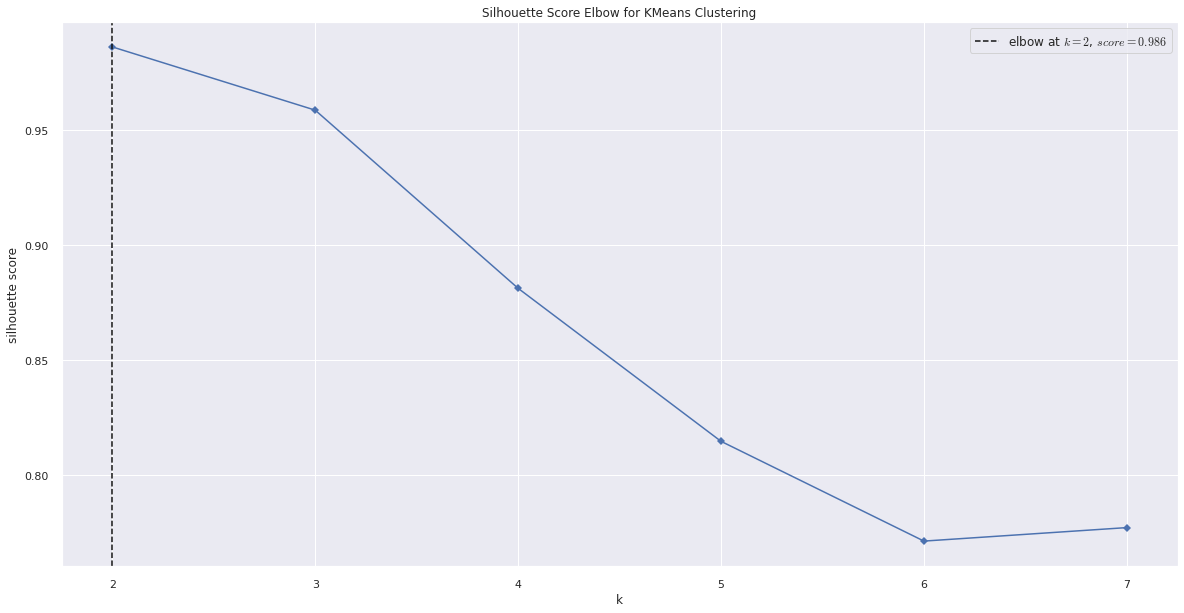

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [45]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit( X )
kmeans.show()

## Sillhouette Analysis

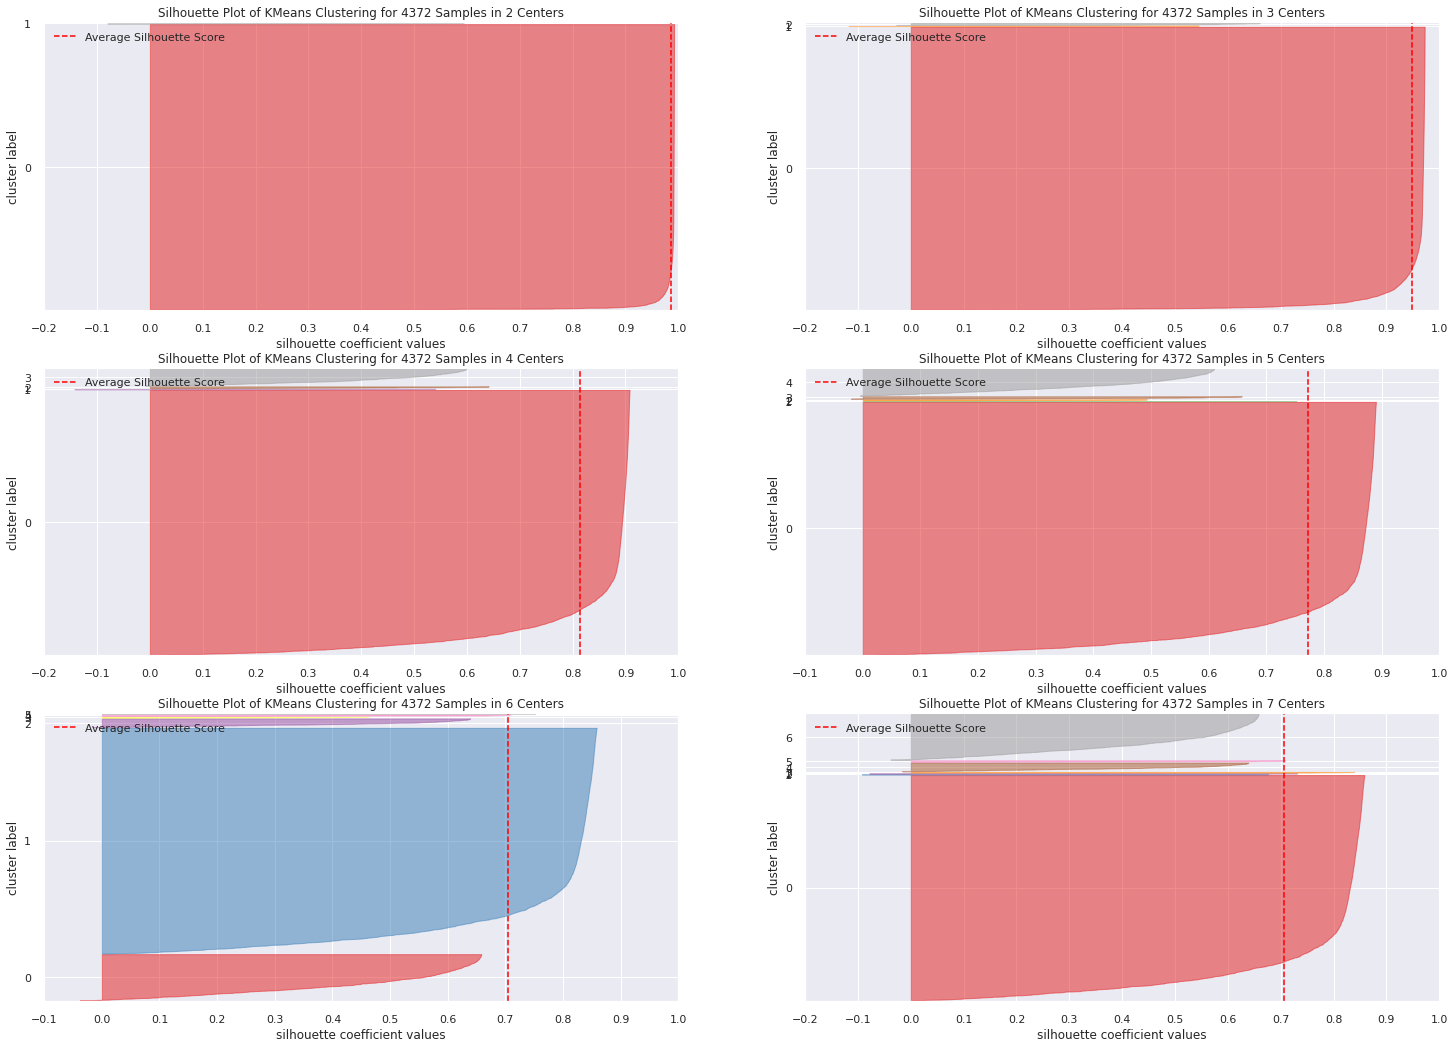

In [46]:
k=2

fig, ax = plt.subplots(3, 2, figsize=(25,18))
for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# Model Training

## K-Means

In [47]:
#model definition
k = 4
kmeans = c.KMeans(init ='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## Cluster Validation

In [48]:
#WSS (Within-cluster sum of square)
print('WSS value: {}'.format( kmeans.inertia_ ) )

# SS (Silhouette Score)
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) ) 

WSS value: 40056506734.60249
SS value: 0.8139972028952444


# Cluster Analysis

In [49]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


In [50]:
df9 = df6.copy()
df9['clusters'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,clusters
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## Vizualization Inspection

/home/alex/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


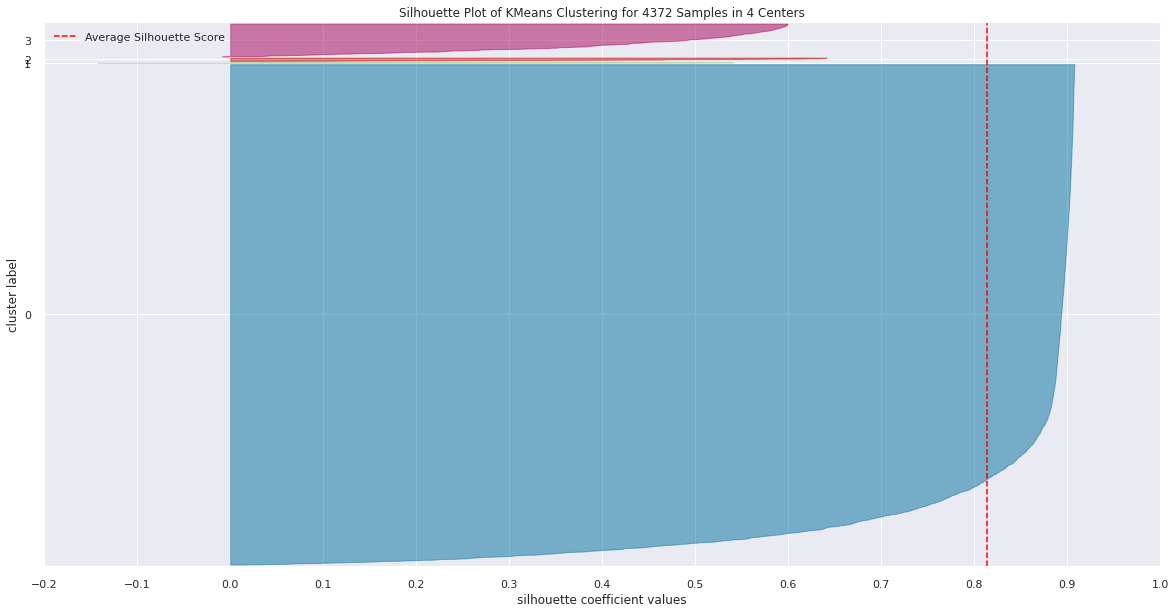

In [51]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='clusters')
#fig.show()

visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 2d Plot

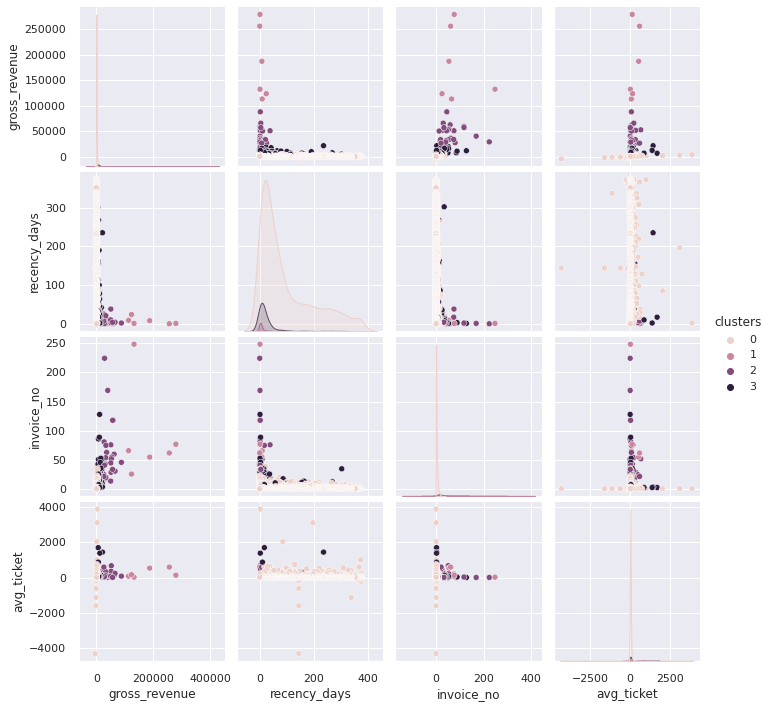

In [52]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='clusters')

## UMAP

Machine Learning - Mainfold
PCA - Matrix, Espaço de Distância - Espaço de Hilbert -  9 condições - Colorários

UMAP - t-SNE (2009) - Mainfold - Topologia

In [53]:
import umap.umap_ as umap

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

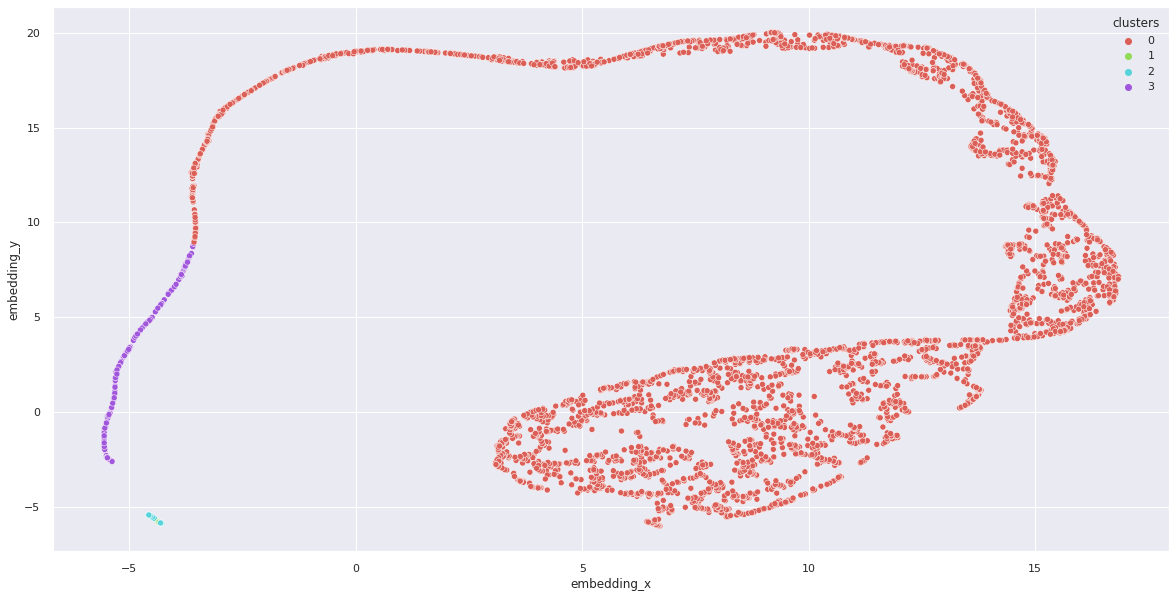

In [54]:
reducer = umap.UMAP( n_neighbors=20, random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='clusters', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique() )), data=df_viz)

## Cluster Profile

In [55]:
#Number of customer
df_cluster = df9[['customer_id', 'clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

#AVG Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='clusters')

#AVG recency days
df_avg_gross_days = df9[['recency_days', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='clusters')

#AVG invoice_no
df_avg_invoice_no = df9[['invoice_no', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='clusters')

#AVG ticket
df_ticket = df9[['avg_ticket', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='clusters')

In [56]:
df_cluster.head()
#gross_revenue = média de gastos
#recency_days = a cada X dias as pessoas estão fazendo compra
#invoice_no = compra em média X produtos


,clusters,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


### Cluster 01: (Candidato a Insider)

- Número de customers: 6 (0.14% do customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:

- Número de customers: 31 (0.71% do customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:

- Número de customers: 4335 (99,15% do customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1372,5 dólares